In [ ]:
import jax.numpy as jnp
import jax.ops as ops
from jax import grad, jit, vmap
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Based on https://github.com/notchia/jax-for-hamiltonian/blob/main/jax_for_hamiltonian.ipynb

In [ ]:
def T(p, m):
  # Kinetic energy of mass m with momentum p
  return 0.5*p**2/m

def V(dx, k):
  # Potential energy of deformation of spring between masses n and n+1, with spring constant k and deformation dx = x_n+1 - x_n
  return 0.5*k*dx**2


def H(x, p, params):
  dx = jnp.diff(jnp.pad(x,(0,1),'constant'))
  T_vec = vmap(T, in_axes=(0,None))(p, params['m'])
  V_vec = vmap(V, in_axes=(0,None))(dx, params['k'])
  H_total = jnp.sum(jnp.add(V_vec, T_vec))

  return H_total

In [ ]:
dHdx = grad(H, argnums=0)
dHdp = grad(H, argnums=1)

def eom_H(t, y, params):
  x, p = jnp.split(y, 2, axis=0)
  dxdt =  dHdp(x, p, params)
  dpdt = -dHdx(x, p, params)
  dydt = jnp.concatenate((dxdt,dpdt), axis=0)

  return dydt

In [ ]:
def initialize(x0, p0, N):
  x = jnp.zeros(N)
  p = jnp.zeros(N)
  x = x.at[0].set(x0)
  p = p.at[0].set(p0)
  y0 = jnp.concatenate((x,p), axis=0)

  return y0

In [ ]:
N = 2
params = {'k':1, 'm':2}
x0 = 0.0
p0 = 1.0

y0 = initialize(x0, p0, N)

In [ ]:
tspan = (0.0,100.0)
method = 'RK45'
rtol = 1e-8
atol = 1e-8
# Solve equations of motion
sol = solve_ivp(eom_H, tspan, y0, method=method, rtol=rtol, atol=atol, args=(params,))

print("time: ", len(sol.t))

time:  826


Text(0, 0.5, 'Position of mass')

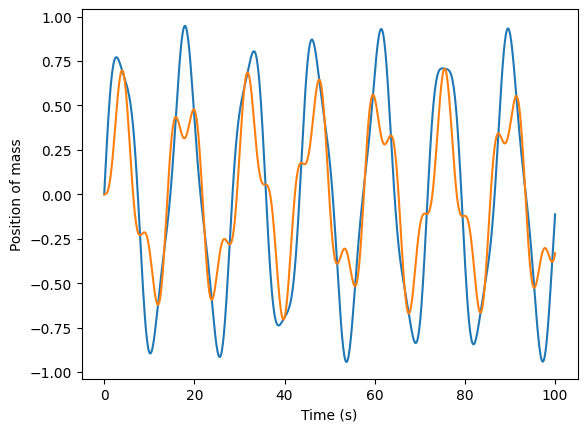

In [ ]:
# Plot displacement of mass over simulation time
plt.figure('solution')
plt.plot(sol.t, sol.y[0])
plt.plot(sol.t, sol.y[1])
plt.xlabel('Time (s)')
plt.ylabel('Position of mass')

(0.0, 0.27500003576278687)

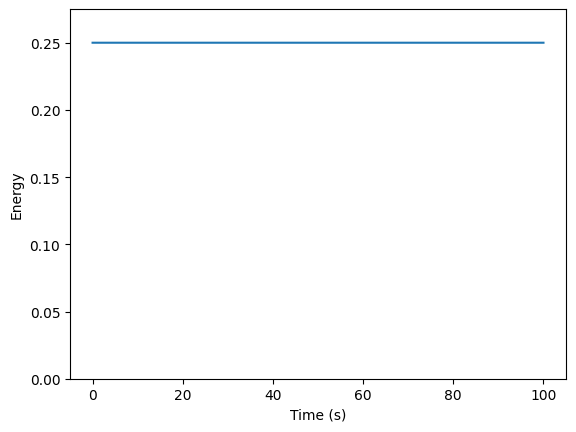

In [ ]:
x_arr, p_arr = jnp.split(sol.y, 2, axis=0)
dx_arr = jnp.diff(x_arr, axis=0)
H_total = vmap(H, in_axes=(1,1,None))(x_arr, p_arr, params)

plt.figure('H_over_time')
plt.plot(sol.t, H_total)
plt.xlabel('Time (s)')
plt.ylabel('Energy')
plt.ylim(0, 1.1*max(H_total))

In [ ]:
def T(v, m):
  # Kinetic energy of mass m with momentum p
  return 0.5*m*v**2

def V(dx, k):
  # Potential energy of deformation of spring between masses n and n+1, with spring constant k and deformation dx = x_n+1 - x_n
  return 0.5*k*dx**2


def L(x, v, params):
  dx = jnp.diff(jnp.pad(x,(0,1),'constant'))
  T_vec = vmap(T, in_axes=(0,None))(v, params['m'])
  V_vec = vmap(V, in_axes=(0,None))(dx, params['k'])
  L_total = jnp.sum(jnp.subtract(V_vec, T_vec))

  return L_total

In [ ]:
dLdx = grad(L, argnums=0)
dLdv = grad(L, argnums=1)

def eom_H(t, y, params):
  x, v = jnp.split(y, 2, axis=0)
  dxdt =  dLdv(x, v, params)
  dvdt = -dLdx(x, v, params)
  dydt = jnp.concatenate((dxdt,dvdt), axis=0)

  return dydt